# Exercises

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

C:\Users\emiel\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


Text(0, 0.5, 'Probability')

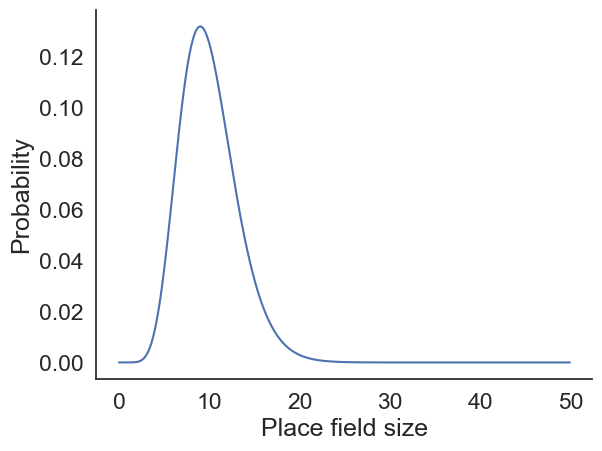

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

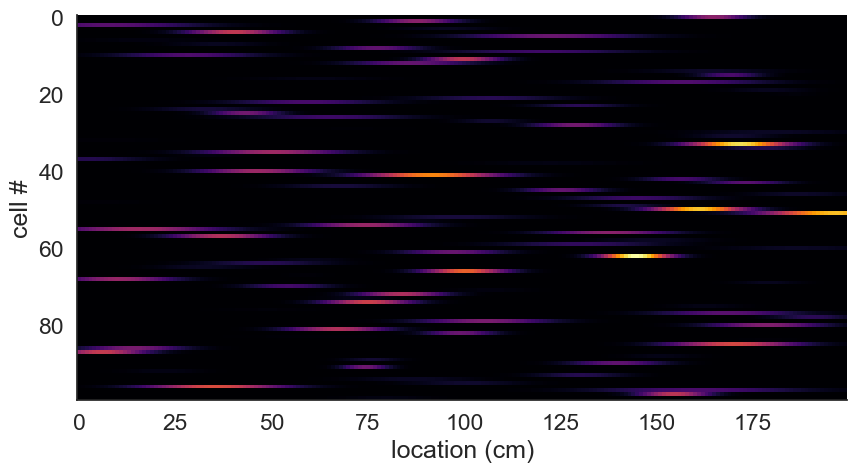

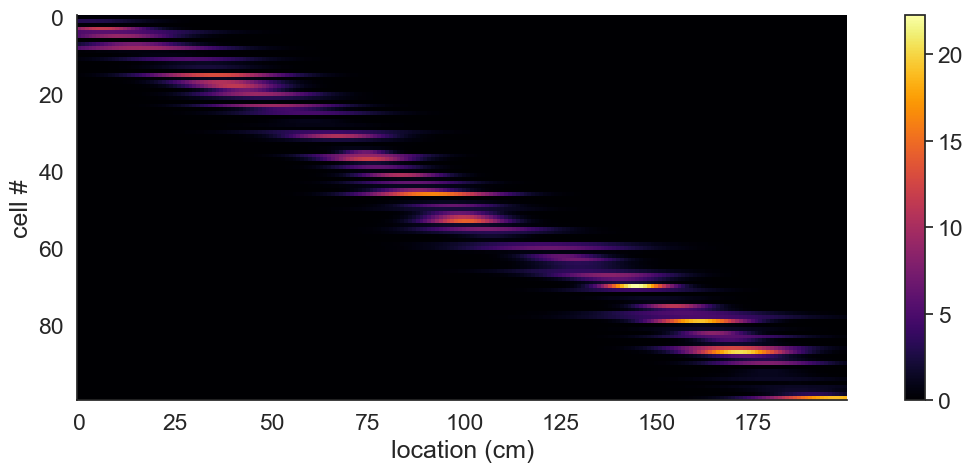

In [3]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

plt.figure(figsize=(10,5))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Text(0, 0.5, 'position on track (cm)')

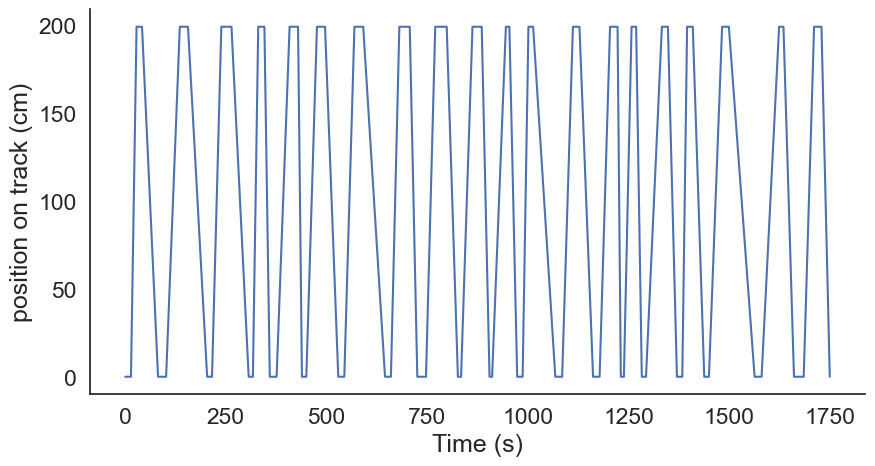

In [4]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

**Code for B**

In [5]:

# B:

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
for noise_firing_rate in [0.01, 0.05, 0.1, 0.5, 1.0]: # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    def plot_unit(i):
        plt.figure(figsize=(10,5))
        plt.plot(t, x)
        plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
        plt.title(f'Baseline noise: {noise_firing_rate} Hz, cell #{i}')
        plt.xlabel('Time (s)')
        plt.ylabel('position on track (cm)')
        
    interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

**Code for A**

C:\Users\emiel\AppData\Local\Temp\ipykernel_9620\1561675861.py:17: RuntimeWarning: divide by zero encountered in divide
  firing_rate_maps = spikes_hist / occupancy
C:\Users\emiel\AppData\Local\Temp\ipykernel_9620\1561675861.py:17: RuntimeWarning: invalid value encountered in divide
  firing_rate_maps = spikes_hist / occupancy


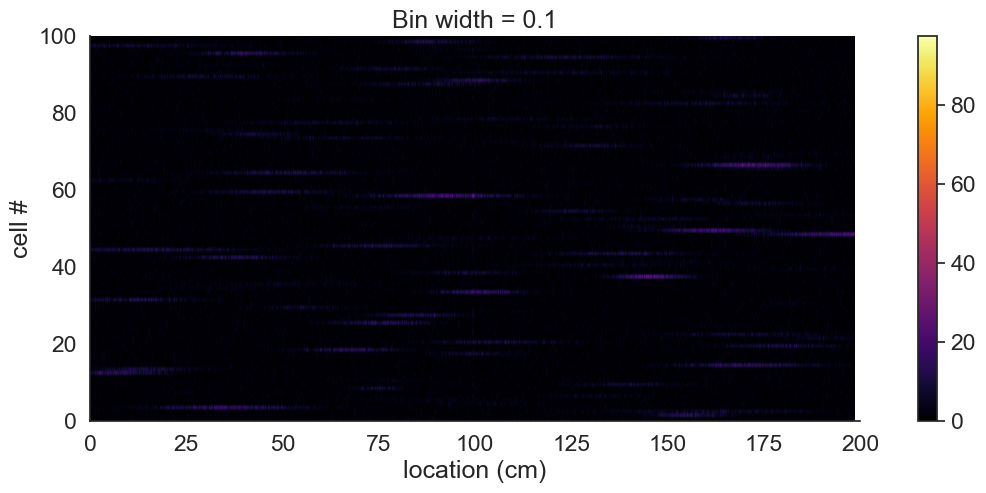

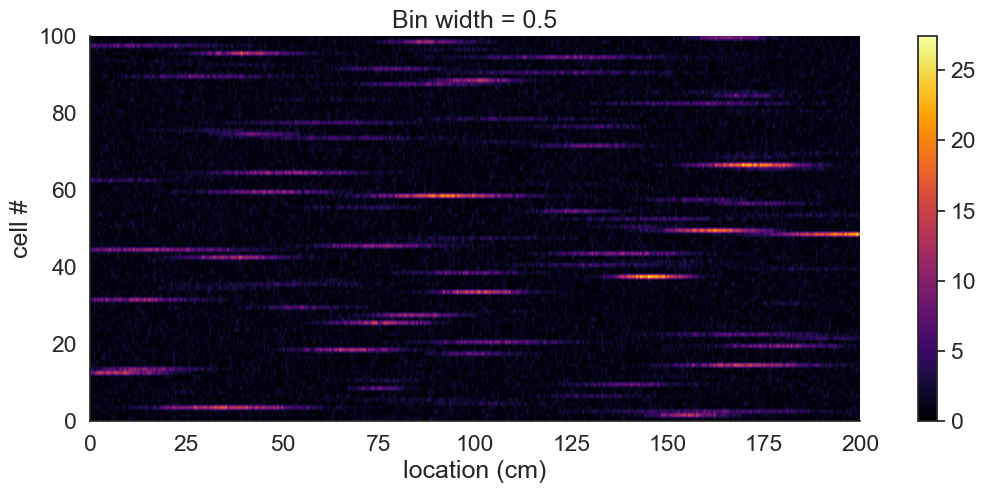

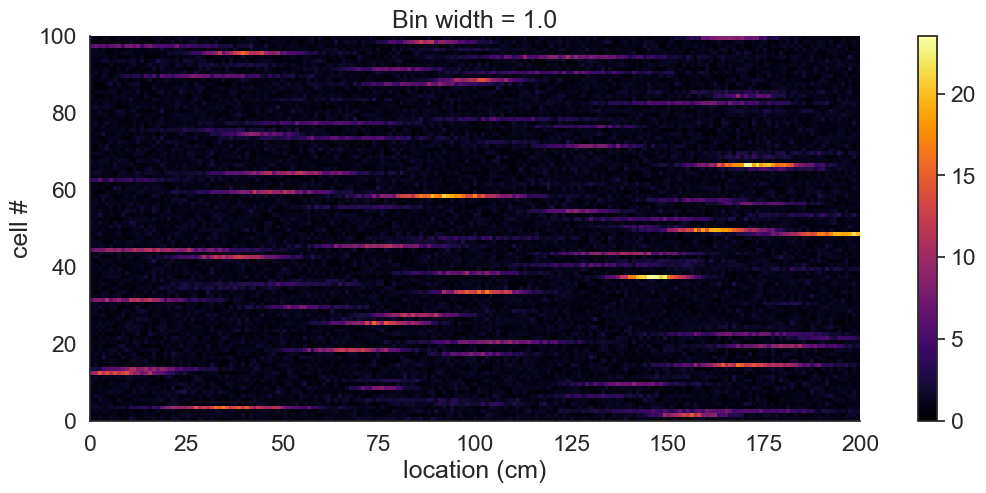

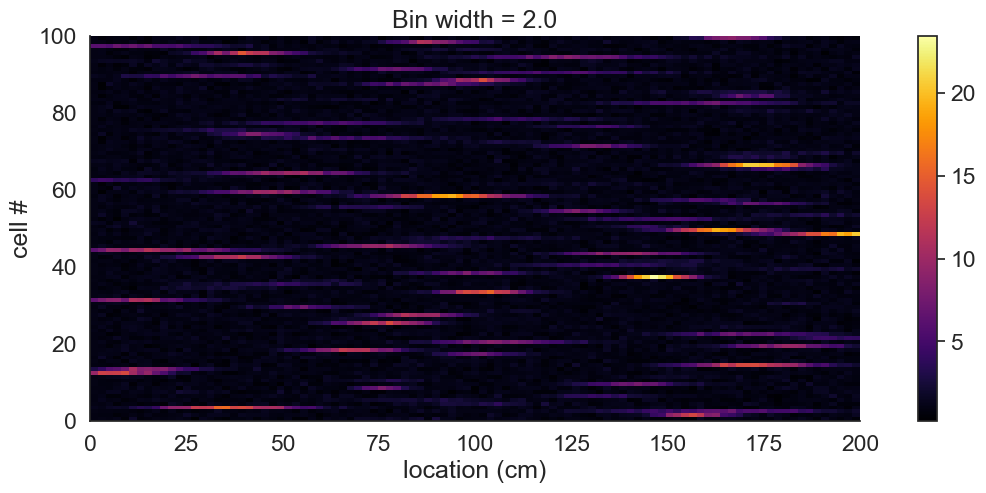

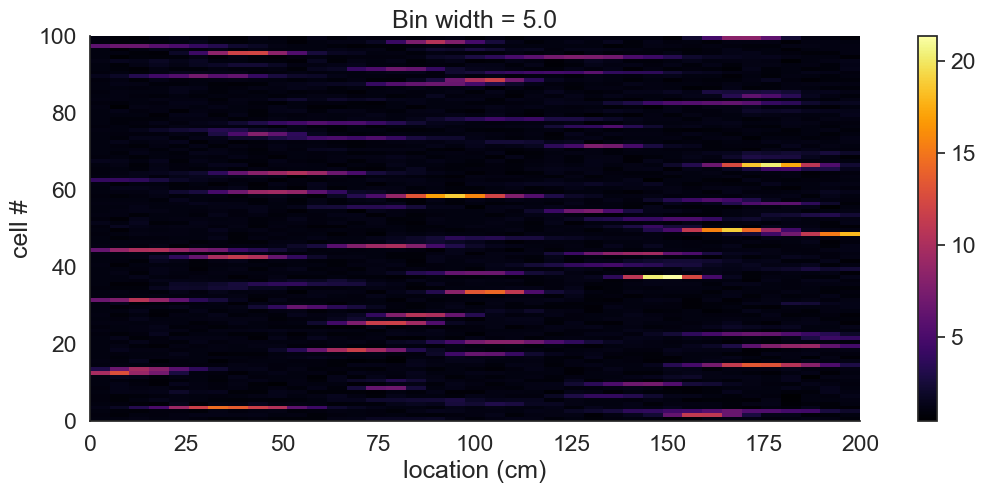

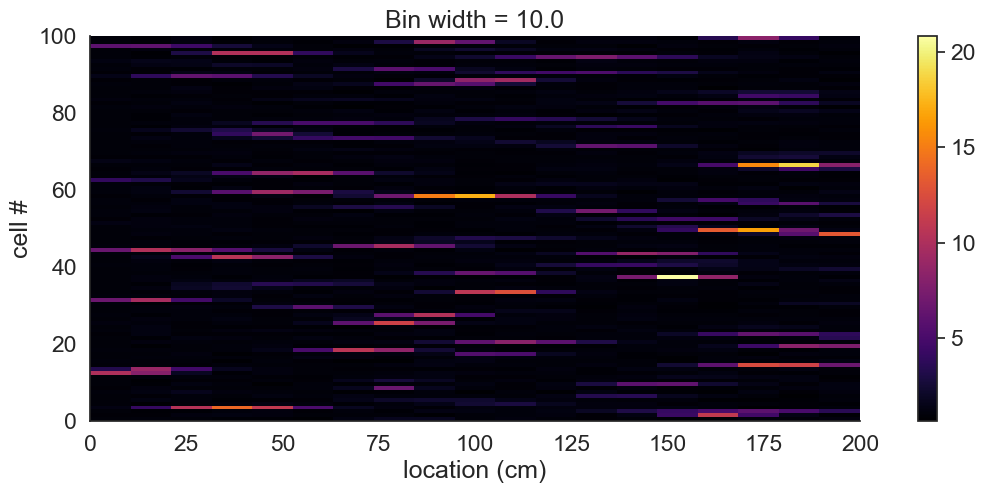

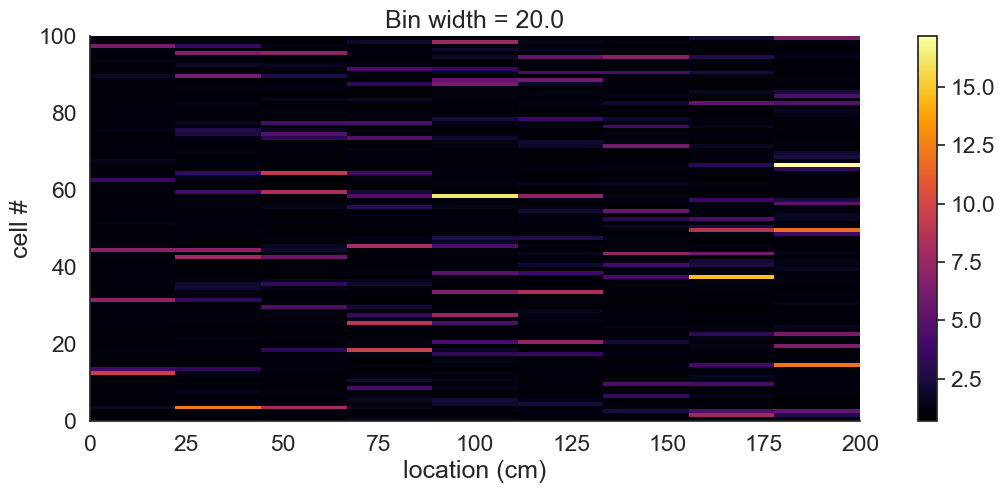

In [6]:
# A:

spike_positions = [np.interp(s, t, x) for s in spikes]

for step in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    space_bins = np.arange(0., 200., step)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Bin width = {step}')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

In [38]:
# C:

from scipy.stats import gaussian_kde

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 1.)

spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

bw = 1.0/np.std(spike_positions, ddof=1)
print(f'Bandwidth for KDE: {bw}')
kde = gaussian_kde(firing_rate_maps, bw_method=bw)
smoothed_firing_rate_maps = kde(firing_rate_maps)

plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.title(f'Bin width = {step}')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

C:\Users\emiel\AppData\Local\Temp\ipykernel_9620\3819119049.py:17: RuntimeWarning: invalid value encountered in divide
  firing_rate_maps = spikes_hist / occupancy


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (72,) + inhomogeneous part.

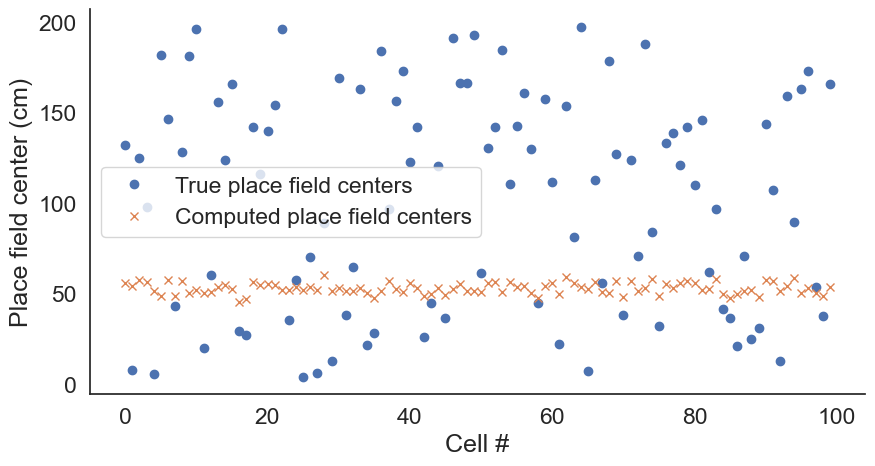

In [57]:
# D:

def c_pf(N_spikes, cell_spikes):
    return (1 / N_spikes) * np.sum(cell_spikes)

spike_positions = [np.interp(s, t, x) for s in spikes]
pf_centers_computed = [c_pf(len(spike_positions[i]), spike_positions[i]) for i in range(n_cells)]
pf_centers_computed = np.array(pf_centers_computed).astype(np.float64)

plt.figure(figsize=(10,5))
plt.plot(pf_centers, 'o', label='True place field centers')
plt.plot(pf_centers_computed, 'x', label='Computed place field centers')
plt.xlabel('Cell #')
plt.ylabel('Place field center (cm)')
plt.legend()
plt.show()

**Exercise 1 Answers**

B: The noise level is defined by "noise_firing_rate"

D: Comparing the computed place field ceneters with the true place field centers (pf_centers), we can see that the computed place field centers all align around the 50 cm line for some reason and are very close together and in-line with each other.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

In [12]:
def mutual_information(firing_rate_map, occupancy, epsilon=10e-15):
    lam = np.mean(firing_rate_map)
    f_x = firing_rate_map * np.log2((firing_rate_map + epsilon) / lam) * occupancy
    return np.sum(f_x, axis=0)

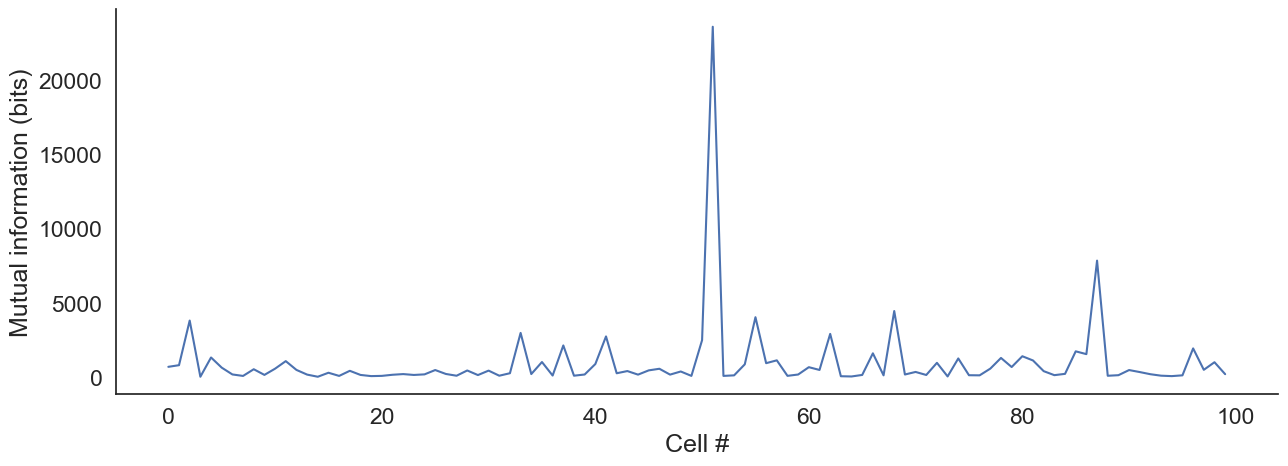

In [14]:
# A:

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 1.)

spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

Is = [mutual_information(firing_rate_maps[i,:], occupancy) for i in range(firing_rate_maps.shape[0])]

plt.figure(figsize=(15,5))
plt.plot(Is)
plt.xlabel('Cell #')
plt.ylabel('Mutual information (bits)')
plt.show()

In [35]:
def systematic_simulation(pf_rate, pf_size, noise_firing_rate):
    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    # pf_size = np.random.gamma(place_field_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    # pf_rate = np.random.exponential(scale=peak_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
    g = scipy.stats.gamma.pdf(x, 10)

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))

    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]

    space_bins = np.arange(0., 200., 1.)

    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy

    Is = [mutual_information(firing_rate_maps[i,:], occupancy) for i in range(firing_rate_maps.shape[0])]

    plt.figure(figsize=(15,5))
    plt.plot(Is)
    plt.xlabel('Cell #')
    plt.ylabel('Mutual information (bits)')
    plt.title(f"Peak firing rate: {np.mean(pf_rate):.2f} Hz, Place field size: {np.mean(pf_size):.2f} cm, Noise firing rate: {noise_firing_rate:.2f} Hz")
    plt.show()

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


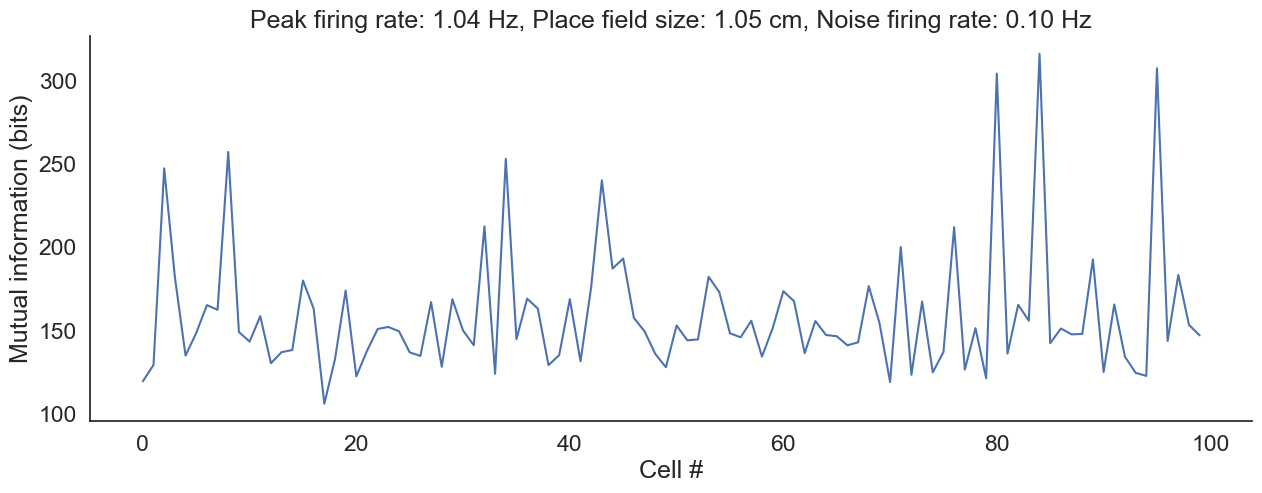

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


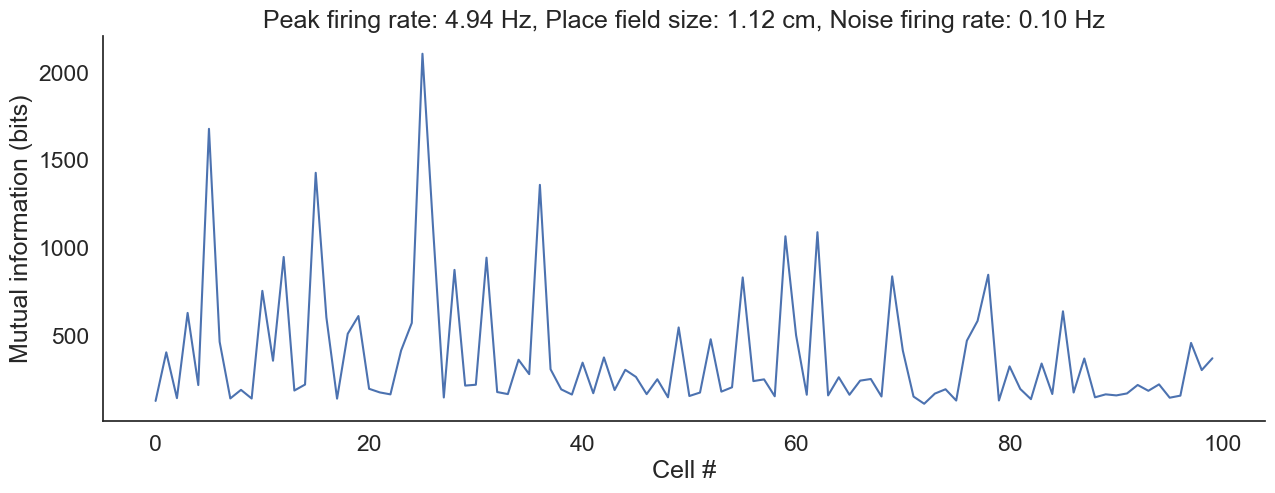

100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


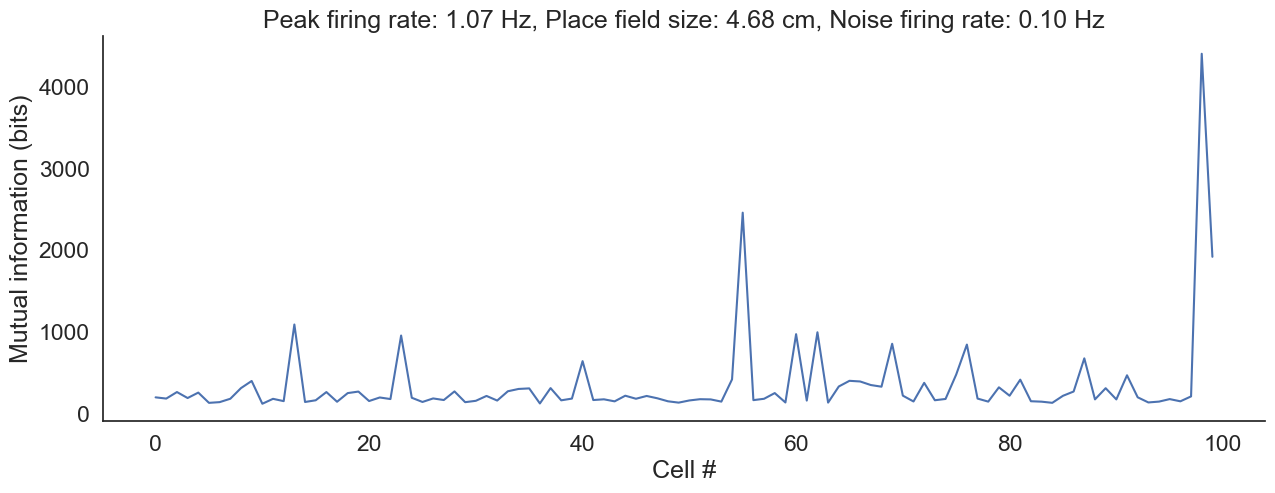

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


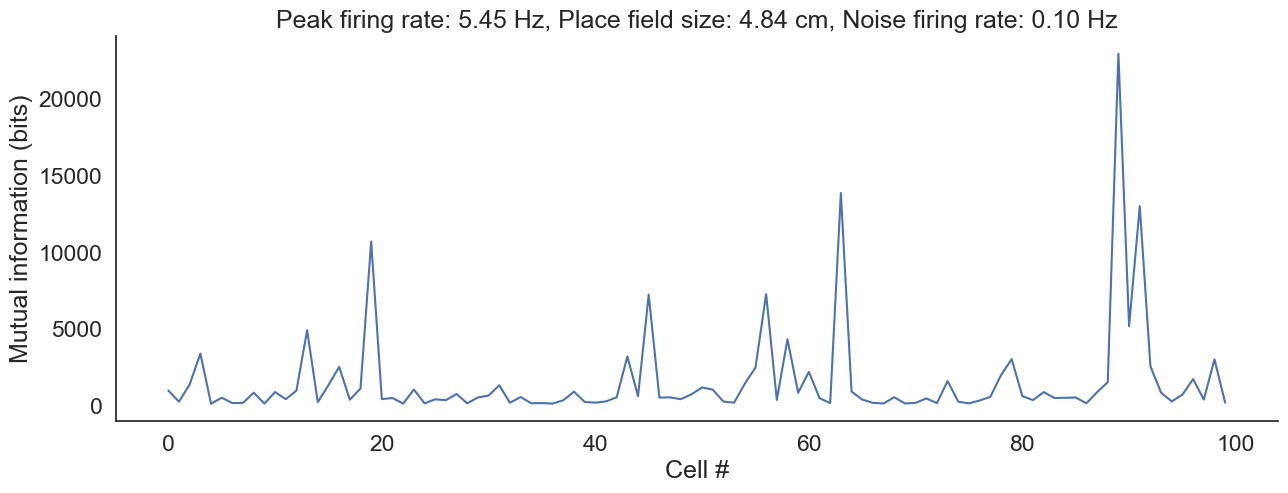

100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


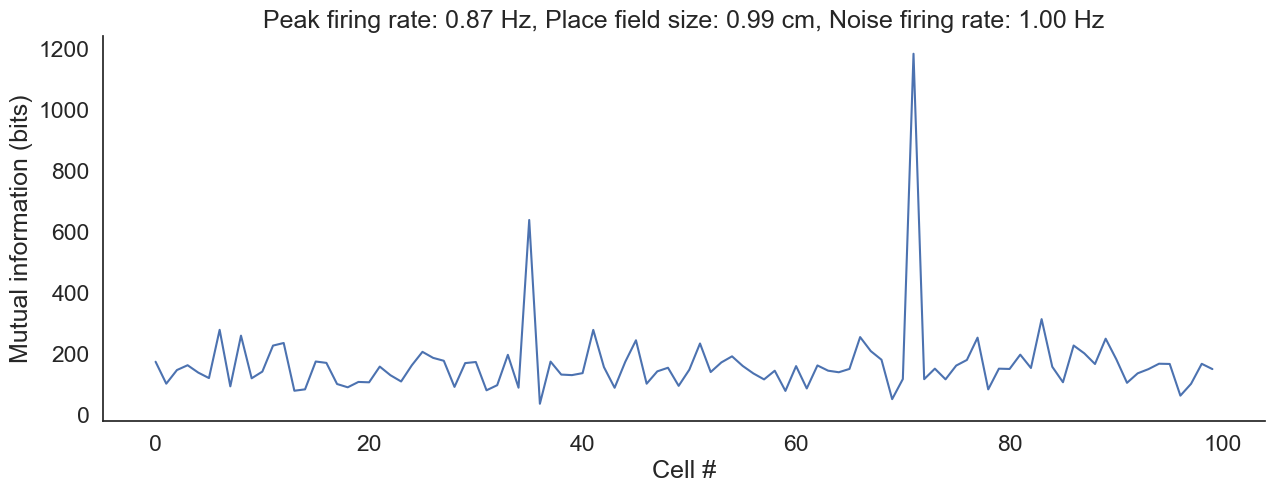

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


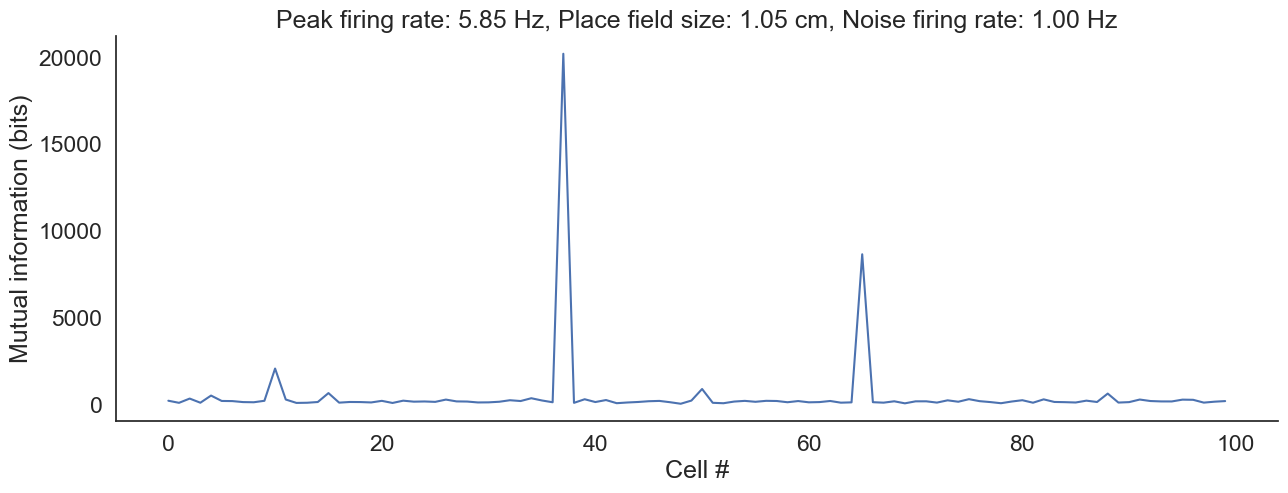

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


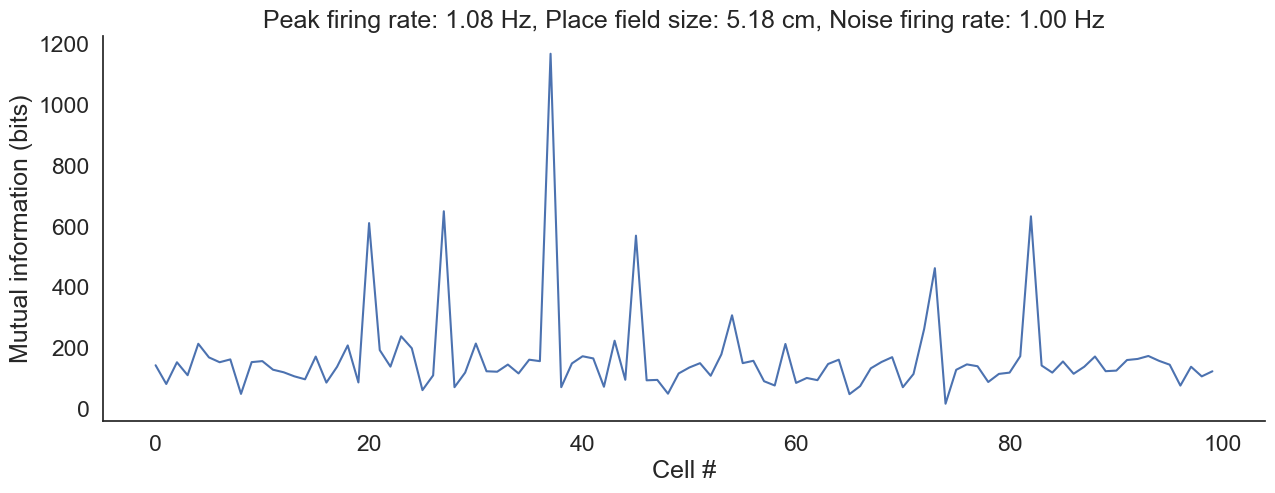

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


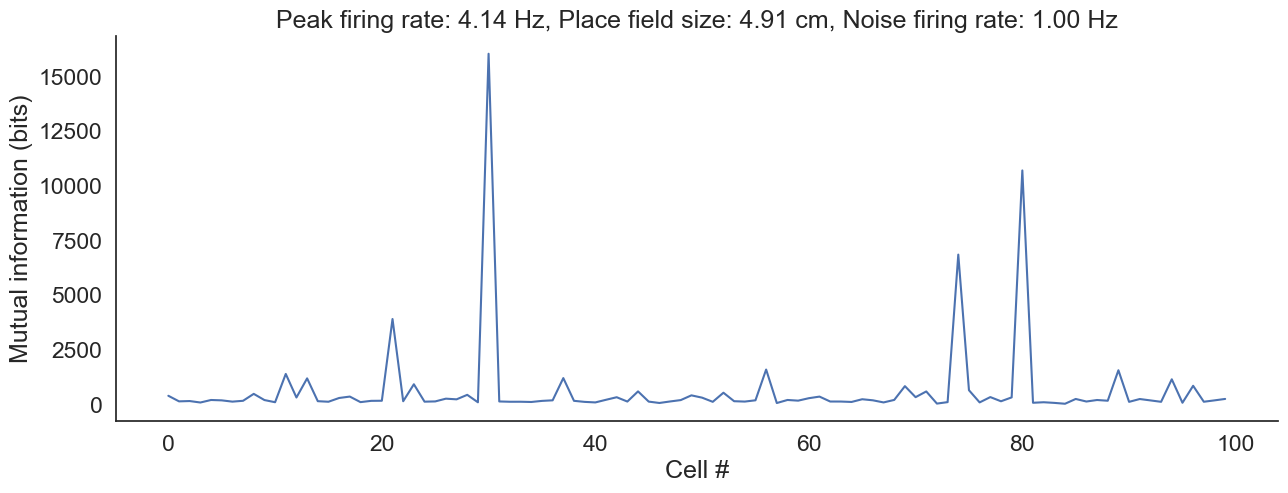

In [50]:
for noise_firing_rate in [0.1, 1.0]: # the baseline noise firing rate
    for pf_size in [1.0, 5.0]: # the size (width) of the place fields, drawn randomly from a gamma distribution 
        for pf_rate in [1.0, 5.0]:
            systematic_simulation(np.random.exponential(scale=pf_rate, size=n_cells), 
                                  np.random.gamma(pf_size, size=n_cells), 
                                  noise_firing_rate)

Comments for exercise 2:
- Increasing the peak firing rate appears to greatly increase the maximum obtainable mutual information, although it does not increase the amount of cells with outstanding amounts of mutual information.
- A small place field size appears to even out the mutual information of each cells, whereas a large place field size seems to allow for more outlying cells.
- I can't exactly determine what the baseline noise does for mutual information, as its effects seem a bit insignificant compared to the other two parameters.

In [37]:
# At the top of your notebook:
from ipywidgets import interact, FloatSlider, IntSlider

# (Make sure systematic_simulation is already defined in the notebook.)

def interactive_simulation(peak_firing_rate=5.0,
                           place_field_size=5.0,
                           noise_firing_rate=0.1,
                           n_cells=100):
    """
    Wrapper that generates pf_rate and pf_size arrays from the slider values,
    then calls your systematic_simulation to redraw the plot.
    """
    pf_rate = np.random.exponential(scale=peak_firing_rate, size=n_cells)
    pf_size = np.random.gamma(place_field_size, size=n_cells)
    
    plt.clf()
    systematic_simulation(pf_rate, pf_size, noise_firing_rate)

interact(
    interactive_simulation,
    peak_firing_rate=FloatSlider(
        value=5.0, min=1.0, max=10.0, step=0.5, description='Peak rate (Hz)'),
    place_field_size=FloatSlider(
        value=5.0, min=1.0, max=20.0, step=1.0, description='PF size (cm)'),
    noise_firing_rate=FloatSlider(
        value=0.1, min=0.0, max=1.0, step=0.01, description='Noise rate (Hz)'),
    n_cells=IntSlider(
        value=100, min=10, max=500, step=10, description='# cells')
)

interactive(children=(FloatSlider(value=5.0, description='Peak rate (Hz)', max=10.0, min=1.0, step=0.5), Float…

<function __main__.interactive_simulation(peak_firing_rate=5.0, place_field_size=5.0, noise_firing_rate=0.1, n_cells=100)>

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [43]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

print(data.keys())

x = data['x']
t = data['t']
spikes = data['spikes']

dict_keys(['x', 't', 'spikes'])


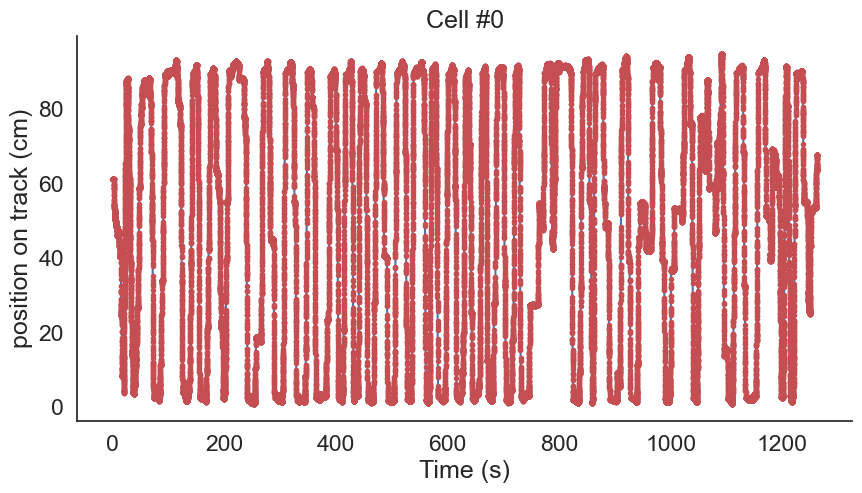

In [44]:
# A:

def plot_cell(t, x, spikes, cell):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[cell], np.interp(spikes[cell], t, x), 'r.')
    plt.title(f'Cell #{cell}')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')


plot_cell(t, x, spikes, 0)

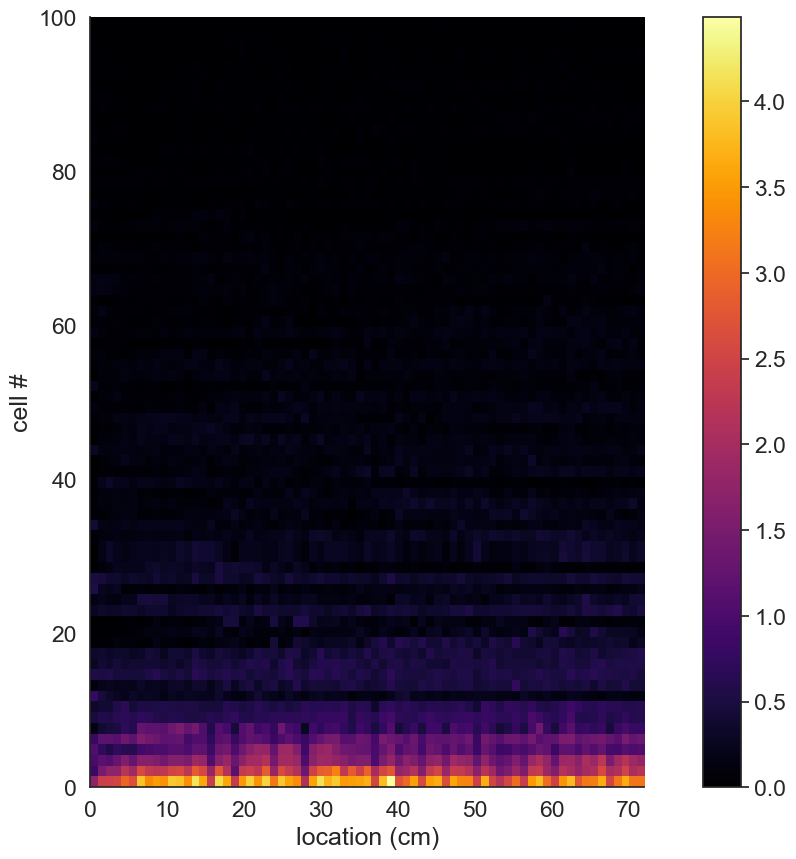

In [45]:
# B:

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., len(spikes), 1.0)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] # /  fps

firing_rate_maps = spikes_hist / occupancy 

peak_firing_rates = np.max(firing_rate_maps, axis=1)
firing_rate_maps = firing_rate_maps[np.argsort(peak_firing_rates),:]

plt.figure(figsize=(15,10))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, len(spikes), 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

In [46]:
def mutual_information(firing_rate_map, occupancy, epsilon=10e-15):
    lam = np.mean(firing_rate_map)
    f_x = firing_rate_map * np.log2((firing_rate_map + epsilon) / lam) * occupancy
    return np.sum(f_x, axis=0)

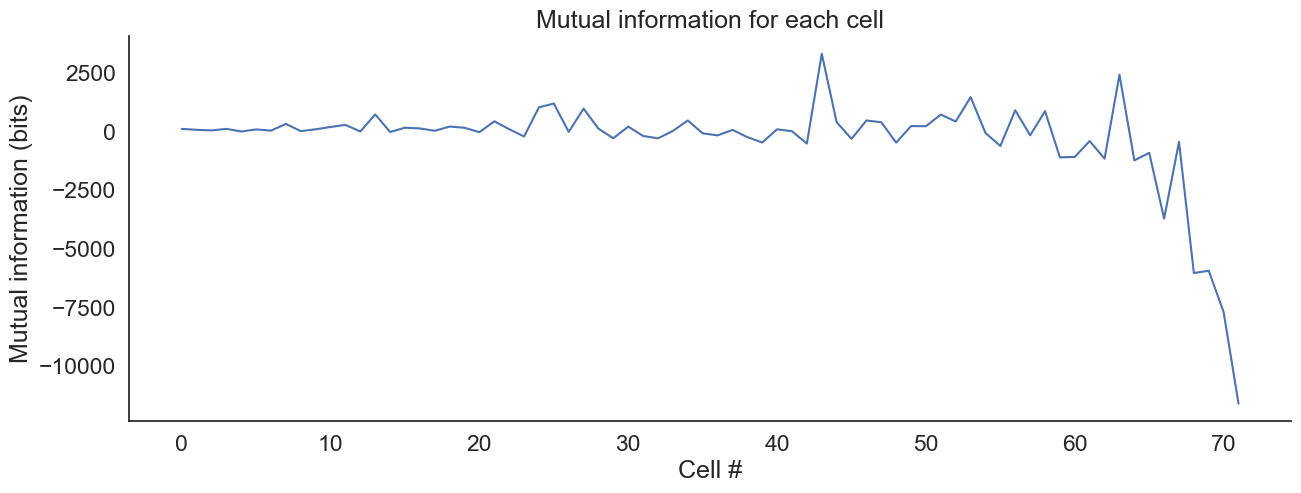

In [47]:
# C:

Is = [mutual_information(firing_rate_maps[i,:], occupancy) for i in range(firing_rate_maps.shape[0])]
plt.figure(figsize=(15,5))
plt.plot(Is)
plt.xlabel('Cell #')
plt.ylabel('Mutual information (bits)')
plt.title('Mutual information for each cell')
plt.show()

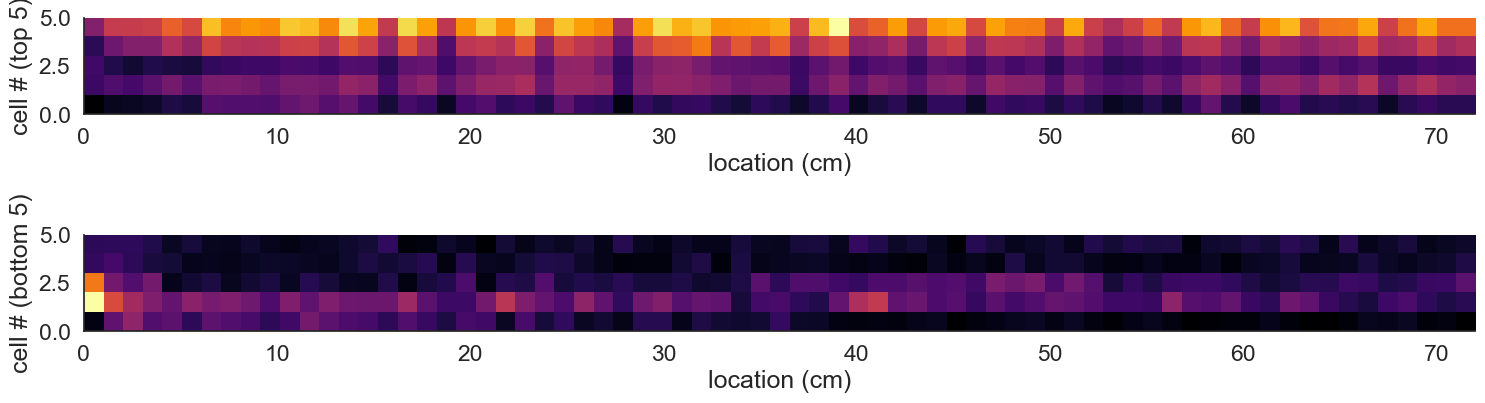

In [49]:
bottom_cells = np.argsort(Is)[-5:]
top_cells = np.argsort(Is)[:5]

plt.figure(figsize=(15,5))
plt.subplot(2, 1, 1)
plt.imshow(firing_rate_maps[top_cells,:], cmap='inferno', extent = [0, len(spikes), 0, len(top_cells)])
plt.xlabel('location (cm)')
plt.ylabel('cell # (top 5)')
plt.subplot(2, 1, 2)
plt.imshow(firing_rate_maps[bottom_cells,:], cmap='inferno', extent = [0, len(spikes), 0, len(bottom_cells)])
plt.xlabel('location (cm)')
plt.ylabel('cell # (bottom 5)')
plt.tight_layout()

Comments on differences:

When looking at the differences in spacial information between the top 5 and bottom 5 cells, we can see two things:
1. The top cells contain more activity in general.
2. The top cells contain more consistent activity, whereas for the bottom cells, it happens that the cell starts out with a ton of activity and oscillates a bit more in activity.